<a href="https://colab.research.google.com/github/baroodb/code/blob/main/big_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf


In [2]:
SOURCE_IMAGE_URL = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
SOURCE_ANNOT_URL = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'
SOURCE_LISTS_URL = 'http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar'

IMG_SIZE = (224, 224)
CHANNEL = 3 
BATCH_SIZE = 32
EPOCHS = 10


In [3]:
download_path = tf.keras.utils.get_file(fname='images.tar', origin=SOURCE_IMAGE_URL, cache_dir='.', untar=True)

793591808/793579520 [==============================] - 15s 0us/step


In [4]:
img_path = os.path.join(os.path.dirname(download_path), 'Images')
img_path

'./datasets/Images'

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(img_path, 
                                                         image_size=IMG_SIZE,
                                                         batch_size=1, 
                                                         validation_split=0.2, 
                                                         subset='training', 
                                                         seed=123)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(img_path, 
                                                         image_size=IMG_SIZE,
                                                         batch_size=1, 
                                                         validation_split=0.2, 
                                                         subset='validation', 
                                                         seed=123)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [7]:
class_names = train_ds.class_names
class_names2 = [element[10:] for element in class_names]
print(class_names[:10])
print(class_names2[:10])

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']
['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']


In [8]:
# lets make a collage 

In [38]:
N_CLASSES = len(class_names)
N_CLASSES

def f_encode(data, label):
  return data, tf.keras.utils.to_categorical(label.numpy(), num_classes=120) 

#
train_ = train_ds.map(lambda data, label: tf.py_function(func=f_encode, inp=[data, label], Tout=[tf.float32, tf.float32]))
val_ = val_ds.map(lambda data, label: tf.py_function(func=f_encode, inp=[data, label], Tout=[tf.float32, tf.float32]))

In [27]:
for images, labels in train_:
  if labels.shape != (1, 120):
    print(True)

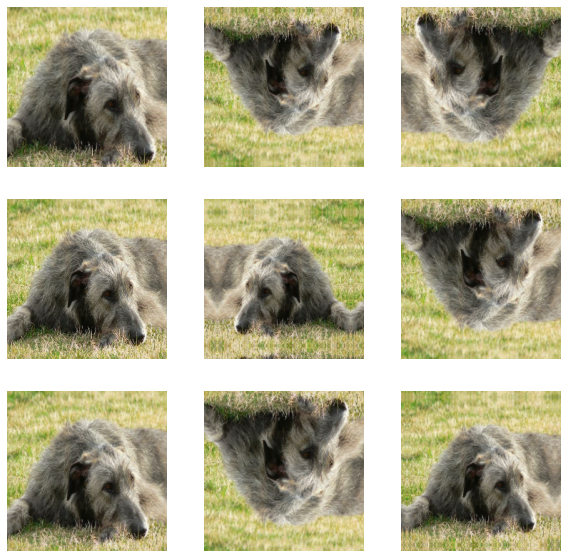

In [10]:
# build the  data augmentation layer
aug = tf.keras.Sequential([
                           tf.keras.layers.experimental.preprocessing.RandomFlip(),
                           tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = aug(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
# think about the model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Softmax
from tensorflow.keras.models import Model

In [25]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)

# freeze all the  layers 
base_model.trainable = False

layers = [layer for layer in base_model.layers]
print(len(layers))

154


In [16]:
# building the mdoel 
inputs = Input(shape=IMG_SIZE+(CHANNEL,))
x = aug(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
#outputs = Dense(N_CLASSES, activation='softmax')(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

lrate = 1e-4

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
#              loss=tf.losses.CategoricalCrossentropy(), 
#              metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [39]:
# building the mdoel """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
inputs = Input(shape=IMG_SIZE+(CHANNEL,))
x = aug(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(120, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)

lrate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
              loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])



model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_9 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_9 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0   

In [40]:
H = model.fit(train_, 
              validation_data=val_, 
              epochs=1)

16464/16464 [==============================] - 382s 23ms/step - loss: 2.3205 - categorical_accuracy: 0.4411 - val_loss: 0.8336 - val_categorical_accuracy: 0.7777


In [ ]:
#lets evaluate the model before training ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
model.evaluate(val_)


In [17]:
#lets evaluate the model before training 
model.evaluate(val_ds)

4116/4116 [==============================] - 85s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0075


[0.0, 0.007531584240496159]

In [ ]:
H = model.fit(train_ds, 
              validation_data=val_ds, 
              epochs=EPOCHS)

In [ ]:
tf.keras.utils.to_categorical([2], num_classes=5 )